In [ ]:
!wget http://www.csc.kth.se/cvap/actions/00sequences.txt

URL transformed to HTTPS due to an HSTS policy
--2023-02-28 14:51:05--  https://www.csc.kth.se/cvap/actions/00sequences.txt
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38292 (37K) [text/plain]
Saving to: ‘00sequences.txt’

00sequences.txt     100%[===================>]  37.39K   186KB/s    in 0.2s    

2023-02-28 14:51:06 (186 KB/s) - ‘00sequences.txt’ saved [38292/38292]



In [ ]:
%cd /content/drive/MyDrive/KTH
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/walking.zip

%cd /content/drive/MyDrive/KTH
!unzip boxing.zip -d boxing
!unzip handclapping.zip -d handclapping
!unzip handwaving.zip -d handwaving
!unzip jogging.zip -d jogging
!unzip running.zip -d running
!unzip walking.zip -d walking

%cd /content/drive/MyDrive/KTH
!rm *.zip

In [ ]:
import cv2
cv2.__version__

'4.6.0'

In [ ]:

import numpy as np
import os
import pickle
import PIL
import re
from PIL import Image
import imageio

In [ ]:
!pip install numpy==1.8.2

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]


In [ ]:
%cd /content/drive/MyDrive/KTH

In [ ]:
!mkdir data

In [ ]:
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

In [ ]:
def prepare_dataset(dataset="train", sequences=None):
    if dataset == "train":
        ID = TRAIN_PEOPLE_ID
    elif dataset == "dev":
        ID = DEV_PEOPLE_ID
    else:
        ID = TEST_PEOPLE_ID

    if sequences == None:
      frames_idx = clean_sequence_file()
    else:
      frames_idx = sequences

    data = []

    for category in CATEGORIES:
        # Get all files in current category's folder.
        folder_path = os.path.join("", "KTH", category)
        filenames = sorted(os.listdir(folder_path))

        for filename in filenames:
            filepath = os.path.join("", "KTH", category, filename)

            # Get id of person in this video.
            person_id = int(filename.split("_")[0][6:])
            if person_id not in ID:
                continue

            vid = imageio.get_reader(filepath, "ffmpeg")

            frames = []

            # Add each frame to correct list.
            for i, frame in enumerate(vid):
                # Boolean flag to check if current frame contains human.
                ok = False
                for seg in frames_idx[filename]:
                    if i >= seg[0] and i <= seg[1]:
                        ok = True
                        break
                if not ok:
                    continue

                # Convert to grayscale.
                frame = Image.fromarray(np.array(frame))
                frame = frame.convert("L")
                frame = np.array(frame.getdata(),
                                 dtype=np.uint8).reshape((120, 160))
                #frame = imresize(frame, (60, 80))

                frames.append(frame)

            data.append({
                "filename": filename,
                "category": category,
                "frames": frames
            })

    pickle.dump(data, open("KTH/data/%s.p" % dataset, "wb+"))

In [ ]:
def clean_sequence_file():
    print("Cleaning dataset/00sequences.txt ...")

    # Read 00sequences.txt file.
    with open('/content/drive/MyDrive/KTH/00sequences.txt', 'r') as content_file:
      for _ in range(20): # Skiping first 20 lines of sequences file (instruction details).
        next(content_file)
      content = content_file.read()

    # Replace tab and newline character with space, then split file's content
    # into strings.
    content = re.sub("[\t\n]", " ", content).split()

    # Dictionary to keep ranges of frames with humans.
    # Example:
    # video "person01_boxing_d1": [(1, 95), (96, 185), (186, 245), (246, 360)].
    frames_idx = {}

    # Current video that we are parsing.
    current_filename = ""

    for s in content:
        if s == "frames":
            # Ignore this token.
            continue
        elif s.find("-") >= 0:
            # This is the token we are looking for. e.g. 1-95.
            if s[len(s) - 1] == ',':
                # Remove comma.
                s = s[:-1]

            # Split into 2 numbers => [1, 95]
            idx = s.split("-")

            # Add to dictionary.
            if not current_filename in frames_idx:
                frames_idx[current_filename] = []
            frames_idx[current_filename].append((int(idx[0]), int(idx[1])))
        else:
            # Parse next file.
            current_filename = s + "_uncomp.avi"

    return frames_idx

In [ ]:
%cd /content/drive/MyDrive
extracted_sequences = clean_sequence_file()
print("Preparing train dataset ...")
prepare_dataset(dataset="train", sequences=extracted_sequences)
print("Preparing dev dataset ...")
prepare_dataset(dataset="dev", sequences=extracted_sequences)
print("Preparing test dataset ...")
prepare_dataset(dataset="test", sequences=extracted_sequences)

/content/drive/MyDrive
Cleaning dataset/00sequences.txt ...
Preparing train dataset ...
Preparing dev dataset ...
Preparing test dataset ...


In [ ]:
import pickle

train_videos = pickle.load(open("/content/drive/My Drive/KTH/data/train.p", "rb"))
valid_videos = pickle.load(open("/content/drive/My Drive/KTH/data/dev.p", "rb"))
test = pickle.load(open("/content/drive/My Drive/KTH/data/test.p", "rb"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_PATHS = train_videos
VAL_PATHS = valid_videos
TEST_PATHS = test


In [ ]:
!pip install mediapipe
import mediapipe as mp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 17.8 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np

mp_pose = mp.solutions.pose

train_poses = []

with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    i = 0
    for video_dict in TRAIN_PATHS:
        print(i)
        frames = video_dict['frames']

        pose_landmarks = []
        for frame in frames:
            # Convert the BGR image to RGB before processing.
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if not results.pose_landmarks:
                pose_landmarks.append(np.zeros((33, 2), dtype=np.float32))
                continue

            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y])

            pose_landmarks.append(np.array(landmarks, dtype=np.float32))

        train_poses.append(np.array(pose_landmarks))
        i = i + 1




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


In [ ]:
# Convert train_poses to numpy array and save to file
train_poses_np = np.array(train_poses)
np.save('train_poses.npy', train_poses_np)
import shutil

shutil.copy("train_poses.npy","/content/drive/MyDrive/Abu_KTH/Mediapipe")

<ipython-input-11-6a9374d3b79a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_poses_np = np.array(train_poses)


'/content/drive/MyDrive/Abu_KTH/Mediapipe/train_poses.npy'

In [ ]:
train_poses_np.shape

In [ ]:
val_poses = []
VAL_PATHS = valid_videos
TEST_PATHS = test
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    i = 0
    for video_dict in VAL_PATHS:
        print(i)
        frames = video_dict['frames']

        pose_landmarks = []
        for frame in frames:
            # Convert the BGR image to RGB before processing.
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if not results.pose_landmarks:
                pose_landmarks.append(np.zeros((33, 2), dtype=np.float32))
                continue

            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y])

            pose_landmarks.append(np.array(landmarks, dtype=np.float32))

        val_poses.append(np.array(pose_landmarks))
        i = i + 1



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [ ]:
# Convert train_poses to numpy array and save to file
val_poses_np = np.array(val_poses)
np.save('val_poses.npy', val_poses_np)
shutil.copy("val_poses.npy","/content/drive/MyDrive/Abu_KTH/Mediapipe")

<ipython-input-13-70b5e09c3bf9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_poses_np = np.array(val_poses)


'/content/drive/MyDrive/Abu_KTH/Mediapipe/val_poses.npy'

In [ ]:
test_poses = []

with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    i = 0
    for video_dict in TEST_PATHS:
        print(i)
        frames = video_dict['frames']

        pose_landmarks = []
        for frame in frames:
            # Convert the BGR image to RGB before processing.
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if not results.pose_landmarks:
                pose_landmarks.append(np.zeros((33, 2), dtype=np.float32))
                continue

            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([landmark.x, landmark.y])

            pose_landmarks.append(np.array(landmarks, dtype=np.float32))

        test_poses.append(np.array(pose_landmarks))
        i = i + 1



In [ ]:
# Convert train_poses to numpy array and save to file
test_poses_np = np.array(test_poses)
np.save('test_poses.npy', test_poses_np)
shutil.copy("test_poses.npy","/content/drive/MyDrive/Abu_KTH/Mediapipe")

<ipython-input-66-5be46969b91d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(a)


In [ ]:
import numpy as np

In [ ]:
train = np.load('/content/drive/MyDrive/Abu_KTH/Mediapipe/train_poses.npy', allow_pickle=True)
val = np.load('/content/drive/MyDrive/Abu_KTH/Mediapipe/val_poses.npy', allow_pickle=True)

In [ ]:
test_videos = test

In [ ]:
test = np.load('/content/drive/MyDrive/Abu_KTH/Mediapipe/test_poses.npy', allow_pickle=True)
test = test.tolist()

In [ ]:
test_labels = []
for video in test_videos:
  test_labels.append(video['category'])
print(len(test_labels))

216


In [ ]:
!pip install mediapipe
import mediapipe as mp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 38.2 MB/s eta 0:00:00


In [ ]:
train = train.tolist()
val = val.tolist()

In [ ]:
train_labels = []

In [ ]:
for video in train_videos:
  train_labels.append(video['category'])
print(len(train_labels))

191


In [ ]:
val_labels = []
for video in valid_videos:
  val_labels.append(video['category'])
print(len(val_labels))

192


In [ ]:
print(val_labels)

['boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'boxing', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handclapping', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving', 'handwaving',

In [ ]:
import numpy as np
import random
from tqdm import tqdm
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from tensorflow.keras.callbacks import *
from keras.layers.convolutional import *
import tensorflow as tf

import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc

from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

#Initialize the setting
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 30 # the length of frames
        self.joint_n = 33 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 6 # the number of class
        self.feat_d = 528
        self.filters = 64


# Temple resizing function
def zoom(p,target_l=64,joints_num=33,joints_dim=2):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
    return p_new

# Calculate JCD feature
def norm_scale(x):
    return (x-np.mean(x))/np.mean(x)

def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        d_m = cdist(p[f],p[f],'euclidean')
        d_m = d_m[iu]
        M.append(d_m)
    M = np.stack(M)
    M = norm_scale(M)
    return M


def data_generator(T,C,le,labels):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T))):
        p = np.copy(T[i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        label = np.zeros(C.clc_num)
        print(len(le.transform(labels)))
        label[le.transform(labels)[i]-1] = 1

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1)
    Y = np.stack(Y)
    return X_0,X_1,Y




#Building the model
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W])
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast

def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=30,joint_n=33,joint_d=2,feat_d=231,filters=16):
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))

    diff_slow,diff_fast = pose_motion(P,frame_l)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d))

    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)

    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model


#Test in real time
# def data_generator_rt(T,C):
#     X_0 = []
#     X_1 = []

#     T = np.expand_dims(T, axis = 0)
#     for i in tqdm(range(len(T))):
#         p = np.copy(T[i])
#         p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

#         M = get_CG(p,C)

#         X_0.append(M)
#         X_1.append(p)

#     X_0 = np.stack(X_0)
#     X_1 = np.stack(X_1)

#     return X_0,X_1

In [ ]:
C = Config()
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 M (InputLayer)                 [(None, 30, 528)]    0           []                               
                                                                                                  
 P (InputLayer)                 [(None, 30, 33, 2)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 3, 512)       1778176     ['M[0][0]',                      
                                                                  'P[0][0]']                      
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 512)         0           ['model_2[0][0]']          

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)


X_0,X_1,Y = data_generator(train,C,le, train_labels)
X_val_0,X_val_1,Y_val = data_generator(val,C, le, val_labels)

  0%|          | 0/191 [00:00<?, ?it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: Deprecati

191
191
191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

191
191
191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

191
191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 22%|██▏       | 42/191 [00:00<00:02, 63.41it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

191
191
191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 29%|██▉       | 56/191 [00:00<00:02, 63.46it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

191
191
191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 37%|███▋      | 70/191 [00:01<00:01, 63.54it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 44%|████▍     | 84/191 [00:01<00:01, 60.84it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 51%|█████▏    | 98/191 [00:01<00:01, 53.39it/s]<ipython-input-21-8a4cfe9cf335>:58: 

191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 54%|█████▍    | 104/191 [00:01<00:01, 52.69it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58:

191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 61%|██████    | 116/191 [00:01<00:01, 50.03it/s]<ipython-input-21-8a4cfe9cf335>:58:

191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

191
191
191
191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

191
191
191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 89%|████████▉ | 170/191 [00:03<00:00, 47.31it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58:

191
191
191
191
191
191
191
191
191

<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `


191
191
191
191
191
191
191


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 97%|█████████▋| 185/191 [00:03<00:00, 40.12it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58:

191
191
191
191
191
191
191
191



  0%|          | 0/192 [00:00<?, ?it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: Deprecat

192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
  5%|▌         | 10/192 [00:00<00:04, 40.75it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 10%|█         | 20/192 [00:00<00:04, 40.10it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 18%|█▊        | 35/192 [00:00<00:03, 39.39it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 23%|██▎       | 45/192 [00:01<00:03, 39.97it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 28%|██▊       | 54/192 [00:01<00:03, 38.39it/s]<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 36%|███▌      | 69/192 [00:01<00:03, 39.58it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 40%|████      | 77/192 [00:01<00:03, 36.60it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 44%|████▍     | 85/192 [00:02<00:03, 33.34it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

192
192
192
192
192
192
192
192
192
192
192
192
192
192


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 96%|█████████▌| 184/192 [00:03<00:00, 66.76it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58:

192
192
192
192
192
192
192
192
192


In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=1200,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_val_0,X_val_1],Y_val)
                    )

Epoch 1/1200
1/1 [==============================] - 14s 14s/step - loss: 2.4026 - accuracy: 0.1204 - val_loss: 1.7441 - val_accuracy: 0.1823 - lr: 0.0010
Epoch 2/1200
1/1 [==============================] - 0s 80ms/step - loss: 1.8433 - accuracy: 0.3298 - val_loss: 1.7156 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 3/1200
1/1 [==============================] - 0s 85ms/step - loss: 1.5738 - accuracy: 0.3979 - val_loss: 1.6959 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 4/1200
1/1 [==============================] - 0s 79ms/step - loss: 1.4783 - accuracy: 0.4188 - val_loss: 1.6875 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 5/1200
1/1 [==============================] - 0s 89ms/step - loss: 1.4191 - accuracy: 0.4921 - val_loss: 1.6809 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/1200
1/1 [==============================] - 0s 117ms/step - loss: 1.1585 - accuracy: 0.6021 - val_loss: 1.6806 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 7/1200
1/1 [==============================] - 0s 74ms/step - loss: 1.

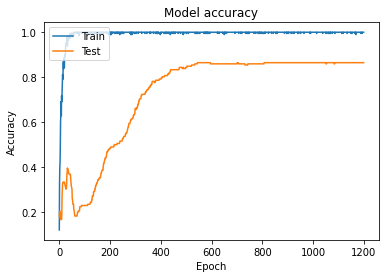

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
X_test_0,X_test_1,Y_test = data_generator(test, C , le, test_labels)

  0%|          | 0/216 [00:00<?, ?it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
  1%|          | 2/216 [00:00<00:11, 18.85it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l

216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
  3%|▎         | 6/216 [00:00<00:11, 18.64it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
  4%|▎         | 8/216 [00:00<00:11, 

216
216
216
216
216
216

<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
  5%|▌         | 11/216 [00:00<00:10, 19.51it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 


216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
  7%|▋         | 16/216 [00:00<00:10, 19.04it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 10%|█         | 22/216 [00:01<00:09, 20.29it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 12%|█▏        | 25/216 [00:01<00:08, 22.46it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 16%|█▌        | 34/216 [00:01<00:05, 31.21it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 20%|██        | 44/216 [00:01<00:04, 37.10it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 24%|██▍       | 52/216 [00:01<00:04, 38.18it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216

<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 28%|██▊       | 60/216 [00:02<00:04, 36.71it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 


216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 31%|███▏      | 68/216 [00:02<00:03, 37.07it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 35%|███▌      | 76/216 [00:02<00:03, 36.52it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 39%|███▉      | 84/216 [00:02<00:03, 36.39it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 43%|████▎     | 92/216 [00:03<00:03, 33.74it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: 

216
216
216
216
216
216
216
216

<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 47%|████▋     | 101/216 [00:03<00:03, 35.91it/s]<ipython-input-21-8a4cfe9cf335>:58:


216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 50%|█████     | 109/216 [00:03<00:02, 35.72it/s]<ipython-input-21-8a4cfe9cf335>:58:

216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

216
216
216
216
216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `

216
216
216
216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 88%|████████▊ | 189/216 [00:04<00:00, 68.79it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58:

216
216
216
216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
 94%|█████████▍| 203/216 [00:04<00:00, 64.55it/s]<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58:

216
216
216
216
216
216
216
216
216
216
216
216
216


<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-21-8a4cfe9cf335>:58: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 216/216 [00:05<00:00, 42.18it/s]


216
216


In [ ]:
metrics = DD_Net.evaluate([X_test_0, X_test_1], Y_test, verbose=0)

# print the evaluation results
print("Validation loss:", metrics[0])
print("Validation accuracy:", metrics[1])

Validation loss: nan
Validation accuracy: 0.8009259104728699


In [ ]:
DD_Net.save("DD_Net_MP_heavy.h5")

In [ ]:
import shutil

shutil.copy("DD_Net_MP_heavy.h5","/content/drive/MyDrive/Abu_KTH/Mediapipe/saved_models/")

'/content/drive/MyDrive/Abu_KTH/Mediapipe/saved_models/DD_Net_MP_heavy.h5'

In [ ]:
class Config():
    def __init__(self):
        self.frame_l = 30 # the length of frames
        self.joint_n = 33 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 6 # the number of class
        self.feat_d = 528
        self.filters = 32

In [ ]:
C = Config()
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 M (InputLayer)                 [(None, 30, 528)]    0           []                               
                                                                                                  
 P (InputLayer)                 [(None, 30, 33, 2)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 3, 256)       468224      ['M[0][0]',                      
                                                                  'P[0][0]']                      
                                                                                                  
 global_max_pooling1d_3 (Global  (None, 256)         0           ['model_6[0][0]']          

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=1200,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_val_0,X_val_1],Y_val)
                    )

Epoch 1/1200
1/1 [==============================] - 6s 6s/step - loss: 2.3746 - accuracy: 0.2042 - val_loss: 1.7779 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/1200
1/1 [==============================] - 0s 80ms/step - loss: 1.9868 - accuracy: 0.2775 - val_loss: 1.7666 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 3/1200
1/1 [==============================] - 0s 117ms/step - loss: 1.8014 - accuracy: 0.3298 - val_loss: 1.7563 - val_accuracy: 0.1510 - lr: 0.0010
Epoch 4/1200
1/1 [==============================] - 0s 119ms/step - loss: 1.6939 - accuracy: 0.3717 - val_loss: 1.7468 - val_accuracy: 0.1615 - lr: 0.0010
Epoch 5/1200
1/1 [==============================] - 0s 77ms/step - loss: 1.4290 - accuracy: 0.4293 - val_loss: 1.7339 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/1200
1/1 [==============================] - 0s 76ms/step - loss: 1.4426 - accuracy: 0.4398 - val_loss: 1.7193 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 7/1200
1/1 [==============================] - 0s 85ms/step - loss: 1.4

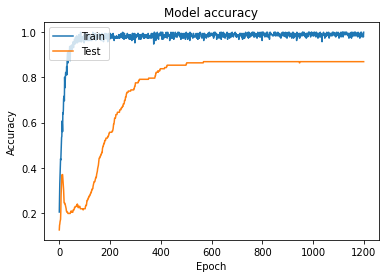

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
metrics = DD_Net.evaluate([X_test_0, X_test_1], Y_test, verbose=0)

# print the evaluation results
print("Validation loss:", metrics[0])
print("Validation accuracy:", metrics[1])

Validation loss: nan
Validation accuracy: 0.7962962985038757


In [ ]:
DD_Net.save("DD_Net_MP_medium.h5")

In [ ]:
import shutil

shutil.copy("DD_Net_MP_medium.h5","/content/drive/MyDrive/Abu_KTH/Mediapipe/saved_models/")

'/content/drive/MyDrive/Abu_KTH/Mediapipe/saved_models/DD_Net_MP_medium.h5'

In [ ]:
class Config():
    def __init__(self):
        self.frame_l = 30 # the length of frames
        self.joint_n = 33 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 6 # the number of class
        self.feat_d = 528
        self.filters = 16

In [ ]:
C = Config()
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 M (InputLayer)                 [(None, 30, 528)]    0           []                               
                                                                                                  
 P (InputLayer)                 [(None, 30, 33, 2)]  0           []                               
                                                                                                  
 model_8 (Functional)           (None, 3, 128)       128896      ['M[0][0]',                      
                                                                  'P[0][0]']                      
                                                                                                  
 global_max_pooling1d_4 (Global  (None, 128)         0           ['model_8[0][0]']          

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=1200,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_val_0,X_val_1],Y_val)
                    )

Epoch 1/1200
1/1 [==============================] - 6s 6s/step - loss: 2.3704 - accuracy: 0.1832 - val_loss: 1.7845 - val_accuracy: 0.1615 - lr: 0.0010
Epoch 2/1200
1/1 [==============================] - 0s 81ms/step - loss: 1.9632 - accuracy: 0.3351 - val_loss: 1.7783 - val_accuracy: 0.1927 - lr: 0.0010
Epoch 3/1200
1/1 [==============================] - 0s 76ms/step - loss: 2.1110 - accuracy: 0.2304 - val_loss: 1.7716 - val_accuracy: 0.1927 - lr: 0.0010
Epoch 4/1200
1/1 [==============================] - 0s 76ms/step - loss: 2.0564 - accuracy: 0.3037 - val_loss: 1.7634 - val_accuracy: 0.2135 - lr: 0.0010
Epoch 5/1200
1/1 [==============================] - 0s 74ms/step - loss: 1.9847 - accuracy: 0.2461 - val_loss: 1.7563 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 6/1200
1/1 [==============================] - 0s 121ms/step - loss: 1.9514 - accuracy: 0.2670 - val_loss: 1.7494 - val_accuracy: 0.2708 - lr: 0.0010
Epoch 7/1200
1/1 [==============================] - 0s 73ms/step - loss: 1.80

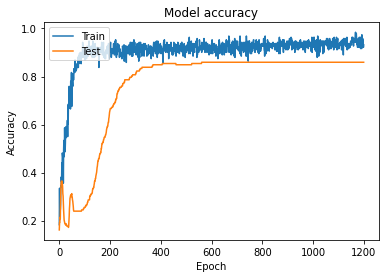

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
metrics = DD_Net.evaluate([X_test_0, X_test_1], Y_test, verbose=0)

# print the evaluation results
print("Validation loss:", metrics[0])
print("Validation accuracy:", metrics[1])

Validation loss: nan
Validation accuracy: 0.7962962985038757


In [ ]:
DD_Net.save("DD_Net_MP_lite.h5")

In [ ]:
import shutil

shutil.copy("DD_Net_MP_lite.h5","/content/drive/MyDrive/Abu_KTH/Mediapipe/saved_models/")

'/content/drive/MyDrive/Abu_KTH/Mediapipe/saved_models/DD_Net_MP_lite.h5'

In [ ]:
class Config():
    def __init__(self):
        self.frame_l = 30 # the length of frames
        self.joint_n = 33 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 6 # the number of class
        self.feat_d = 528
        self.filters = 64

In [ ]:
C = Config()
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 M (InputLayer)                 [(None, 30, 528)]    0           []                               
                                                                                                  
 P (InputLayer)                 [(None, 30, 33, 2)]  0           []                               
                                                                                                  
 model_10 (Functional)          (None, 3, 512)       1778176     ['M[0][0]',                      
                                                                  'P[0][0]']                      
                                                                                                  
 global_max_pooling1d_5 (Global  (None, 512)         0           ['model_10[0][0]']        

In [ ]:


lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_val_0,X_val_1],Y_val)
                    )
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_val_0,X_val_1],Y_val)
                    )

Epoch 1/600
1/1 [==============================] - 6s 6s/step - loss: 2.4488 - accuracy: 0.1832 - val_loss: 1.7532 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/600
1/1 [==============================] - 0s 96ms/step - loss: 1.6900 - accuracy: 0.3613 - val_loss: 1.7069 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 3/600
1/1 [==============================] - 0s 87ms/step - loss: 1.5780 - accuracy: 0.3874 - val_loss: 1.6717 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 4/600
1/1 [==============================] - 0s 89ms/step - loss: 1.4434 - accuracy: 0.4712 - val_loss: 1.6602 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 5/600
1/1 [==============================] - 0s 90ms/step - loss: 1.2012 - accuracy: 0.5288 - val_loss: 1.6644 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/600
1/1 [==============================] - 0s 90ms/step - loss: 0.9636 - accuracy: 0.6911 - val_loss: 1.6798 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 7/600
1/1 [==============================] - 0s 90ms/step - loss: 0.9839 - acc

In [ ]:
metrics = DD_Net.evaluate([X_test_0, X_test_1], Y_test, verbose=0)

# print the evaluation results
print("Validation loss:", metrics[0])
print("Validation accuracy:", metrics[1])

Validation loss: nan
Validation accuracy: 0.7870370149612427
